In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Бактериемия у пациентов многопрофильного стационара

# Дататон 2022, команда Data Intelligence

В датасете представлены данные посева крови пациентов многопрофильного стационара за 3 года: 2017, 2018 и 2019. 
Посев выполняется на селективных средах с целью идентификации бактерий, которые могут присутствовать в образцах.
Представлены данные о  данных о контаминации материала; времени (в рабочих днях), затраченном на получение результата; антибиотикограмм; систем, которые применялись в работе; эпизодах задержки материала из отделения на срок более суток; диагнозах; отделениях; видах и родах микроорганизмов

Признаки в датасете описаны в файле README

Подготовленные данные предназначены для применения моделей машинного обучения с целью предсказания продолжительности и результата культивирования образцов. Продолжительность культивирования имеет значение для выбора лечения и для планирования ресурсов.

В данном ноутбуке представлен анализ распределений и связей между признаками. Кроме того, подгтовлена модель для предсказания, будет ли получен ответ быстро в случае положительного ответа.

## Описание данных

In [3]:
df = pd.read_csv('data/blood_data.csv')

In [4]:
df.head()

,year,month,num,department,diagnosis,delay,duration,method,contamination,group,genus,species
0,2017,Январь,1,Реанимация,ОПН(острая почечная недостаточность),0,3,auto,0,0,0,0
1,2017,Январь,2,Терапия,ЛНГ(лихорадка неясного генеза),0,3,manual,0,0,0,0
2,2017,Январь,3,Пульмонология,Бронхиальная астма,0,3,manual,0,0,0,0
3,2017,Январь,4,Терапия,Цироз,0,3,manual,0,0,0,0
4,2017,Январь,5,Пульмонология,Пневмония,0,4,manual,0,Кокки,Staphylococcus,St. aureus


Описание данных в колонках:
* year - год
* month - месяц
* num - сквозная нумерация для каждого месяца
* department - отделение стационара, из которого поступил образец
* diagnosis - диагноз пациента
* delay - время от забора материала до начала исследования
* duration - продолжительность культивирования до получения результата
* method - способ культивирования и регистрации: ручной manual или автоматический auto
* contamination - контаминация материала (1) или отсутствие контаминации (0)
* group - группа микроорганизмов
* genus - род микроорганизмов
* species - вид микроорганизмов

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9333 entries, 0 to 9332
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   year           9333 non-null   int64 
 1   month          9333 non-null   object
 2   num            9333 non-null   int64 
 3   department     9333 non-null   object
 4   diagnosis      9333 non-null   object
 5   delay          9333 non-null   int64 
 6   duration       9333 non-null   int64 
 7   method         9333 non-null   object
 8   contamination  9333 non-null   int64 
 9   group          9333 non-null   object
 10  genus          9333 non-null   object
 11  species        9333 non-null   object
dtypes: int64(5), object(7)
memory usage: 875.1+ KB


### Значения в столбцах

**Диагнозы**

In [6]:
df.diagnosis.unique()

array(['ОПН(острая почечная недостаточность)',
       'ЛНГ(лихорадка неясного генеза)', 'Бронхиальная астма', 'Цироз',
       'Пневмония', 'Бактериальная инфекция', 'Отит',
       'Осложнение после родов', 'Рак', 'Ревматоидный артрит',
       'ХПН (хроническая почечная недостаточность)', 'Кротечение', 'ОНМК',
       'Кома', 'Почечная колика', 'ОРВИ', 'Инфаркт миокарда', 'Ангина',
       'ХОБЛ (хроническая обструктивная болезнь лёгких)',
       'ТТЖ (тупая травма живота)', 'Энцефалопатия',
       'ЖКК (желудочно-кишечными кровотечениями)', 'Сепсис',
       'Гломерулонефрит', 'Стеноз', 'ЖКБ (жёлчнокаменная болезнь)',
       'Абсцесс', 'Пиелонефрит', 'Эпистатус',
       'МКБ (мочекаменная болезнь)', 'Ожог', 'СД (Сахарный диабет)',
       'Бактериальный эндокардит', 'Холецистит',
       'ИБС (ишемическая болезнь сердца)', 'Панкреатит', 'Перитонит',
       'Эндометрит', 'Свищ', 'Колото-резаные раны ',
       'ПОХ (поясничный остеохондроз)', 'Ампутация', 'Невралгия',
       'Сочетанная травм

**Отделения**

In [7]:
df.department.unique()

array(['Реанимация', 'Терапия', 'Пульмонология', 'Гинекология',
       'Хирургия', 'Ревматология', 'Урология', 'Нефрология',
       'Кардиология', 'Неврология', 'ЧЛХ', 'Глазное/ЛОР',
       'Гастроэнтерология', 'Ожог', 'Поликлиника', 'Травма',
       'Эндокринология', 'Нейрохирургия'], dtype=object)

**Группы бактерий**

In [8]:
df.group.unique()

array(['0', 'Кокки', 'Энтеробактерии', 'НГОБ', 'Анаэробы', 'Прочее',
       'Грибы'], dtype=object)

**Рода бактерий**

In [9]:
df.genus.unique()

array(['0', 'Staphylococcus', 'Klebsiella', 'Streptococcus',
       'Acinetobacter', 'Escherichia', 'Enterococcus', 'Pseudomonas',
       'Enterobacter', 'Serratia', 'анаэр', 'Proteus', 'Stenotrophomonas',
       'Burkholderia', 'Corynebacterium', 'Rothia', 'Micrococcus',
       'Аchromobacter', 'Salmonella', 'Candida', 'Bacillus',
       'Sphingomonas', 'Clostridium', 'Aicaligenes', 'Ochrobactrum',
       'Citrobacter', 'Cryptococcus', 'Peptococcus', 'Lactobacillus',
       'Morganella', 'Oligella', 'Brevundimonas'], dtype=object)

**Виды бактерий**

In [10]:
df.species.unique()

array(['0', 'St. aureus', 'St. epidermidis', 'Kl. pneumoniae',
       'Str. pneumoniae', 'Ac. baumannii', 'E. coli', 'Ent. faecium',
       'Ps. alcaligenes', 'Ent. faecalis', 'St. warneri',
       'Enterobacter cloacae', 'Ser. marcescens', 'Bacteroides fragilis',
       'St. heamolyticus', 'Ps. aeruginosa', 'Clostridium spp.',
       'St. intermedis', 'Prot. mirabilis',
       'Stenotrophomonas maltophilia', 'Str. viridans',
       'Pantoea agglomerans', 'Ac. junii', 'Ent. durans',
       'St. saprophyticus', 'St. kloosii', 'Burkholderia ceprcia',
       'Ac. haemolyticus', 'Str. salivarius', 'Str. mitis',
       'Burkholderia cepecia', 'Ac. lwoffii', 'Corynebacterium spp.',
       'St. capitis', 'Rothia mucilaginosa', 'Micrococcus spp.',
       'St. hemolyticus', 'Аchromobacter species', 'Salm. interitidis',
       'C. albicans', 'Bacillus spp.', 'Can. glabrata', 'St. hominis',
       'Prot. vulgaris', 'Sphingomonas paucimobilis', 'Ac. species',
       'Aicaligenes faecalis', 'Str. p

### Датасет с отфильтрованными положительными результатами

Создадим бинарный признак для положительных/отрицательных результатов и разделим выборку на исследования с положительным и с отрицательным результатом

In [11]:
#создаем признак positive со значениями 1 и 0
df['positive'] = df['species'].apply(lambda x: 0 if x == '0' else 1)

#создаем датасеты с положительными и отрицательными результатами
pos = df.loc[df["positive"] != 0].copy()
neg = df.loc[df["positive"] == 0].copy()

## Визуализация распределения данных

### Пожительные и отрицательные результаты

Доли положительных и отрицательных результатов в выполненных исследованиях

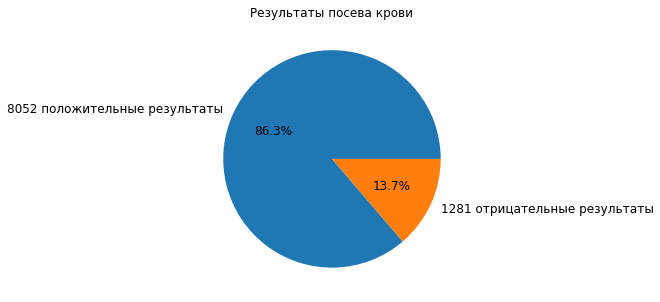

In [12]:
fig = plt.figure(figsize=(5, 5))

plt.title("Результаты посева крови")
plt.pie(
    [neg.count()[0], pos.count()[0]],
    labels=[
        f"{neg.count()[0]} положительные результаты",
        f"{pos.count()[0]} отрицательные результаты",
    ],
    textprops={"fontsize": 12},
    autopct='%1.1f%%'
);

### Распределение положительных результатов по группам, родам и видам микроорганизмов

Распределение по группам

<AxesSubplot:xlabel='count', ylabel='group'>

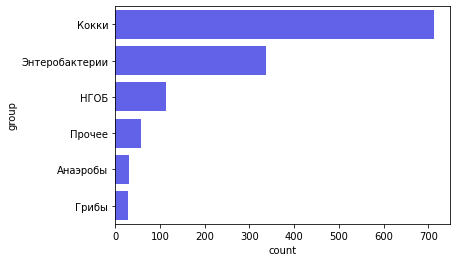

In [13]:
desc = pos.groupby('group').size().sort_values().index[::-1]
sns.countplot(data=pos, y="group", alpha=.7, color = 'b', order = desc)

Распределение по родам, для 15 наиболее часто встречающихся

<AxesSubplot:xlabel='count', ylabel='genus'>

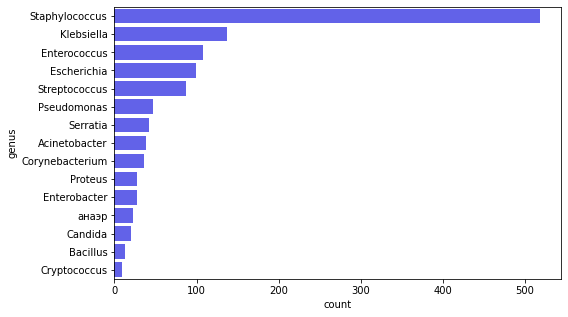

In [14]:
plt.figure(figsize=(8, 5))
desc = pos.groupby('genus').size().nlargest(15).sort_values().index[::-1]
sns.countplot(data=pos, y="genus", alpha=.7, color = 'b', order = desc)

Распределение по видам, для 20 наиболее часто встречающихся

<AxesSubplot:xlabel='count', ylabel='species'>

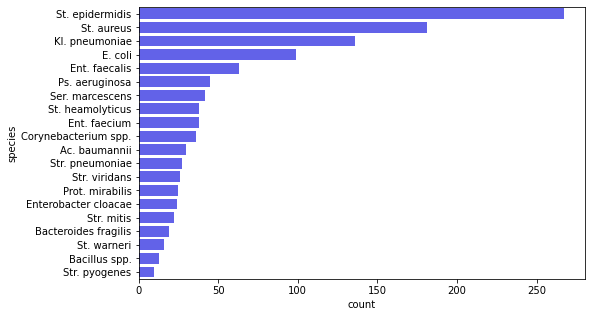

In [15]:
plt.figure(figsize=(8, 5))
desc = pos.groupby('species').size().nlargest(20).sort_values().index[::-1]
sns.countplot(data=pos, y="species", alpha=.7, color = 'b', order = desc)

### Распределение положительных результатов по отделениям

<AxesSubplot:xlabel='count', ylabel='department'>

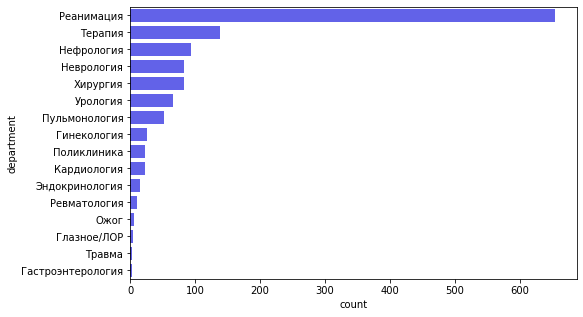

In [16]:
plt.figure(figsize=(8, 5))
desc = pos.groupby('department').size().sort_values().index[::-1]
sns.countplot(data=pos, y="department", alpha=.7, color = 'b', order = desc)

### Сводная таблица для количества и доли положительных результатов по отделениям

Сортировка по доле положительных результатов, по убыванию

In [17]:
df.pivot_table(
index = 'department',
    values = 'positive',
    aggfunc=['count', 'sum', 'mean']
).sort_values(by = ('mean', 'positive'), ascending = False)

,count,sum,mean
,positive,positive,positive
department,,,
Эндокринология,70,15,0.214286
Реанимация,3240,655,0.202160
Нефрология,536,94,0.175373
Неврология,526,83,0.157795
Хирургия,537,82,0.152700
Ожог,41,6,0.146341
Поликлиника,180,23,0.127778
Кардиология,192,22,0.114583


### Распределение по длительности культивирования

Для всех исследований

<AxesSubplot:xlabel='duration', ylabel='count'>

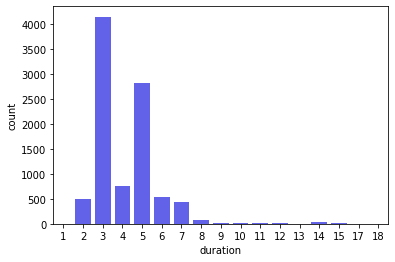

In [18]:
sns.countplot(data=df, x="duration", alpha=.7, color = 'b') 

Для положительных результатов

<AxesSubplot:xlabel='duration', ylabel='Density'>

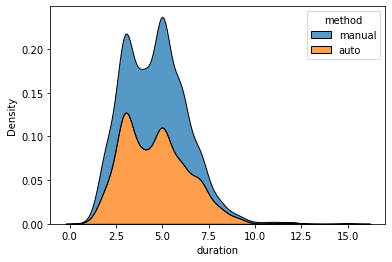

In [19]:
sns.kdeplot(data=pos, x="duration", hue="method", multiple="stack")

Интересно, что оба метода дают два пика по продолжительности культивирования. Определим медианные значения продолжительности культивирования для всех образцов и для положительных образцов

In [20]:
# медиана продолжительности культивирования
print('Медианная продолжительность культивирования для всех образцов, дней:', df.duration.median())

Медианная продолжительность культивирования для всех образцов, дней: 4.0


In [21]:
# медиана продолжительности культивирования
print('Медианная продолжительность культивирования для положительных образцов, дней:', pos.duration.median())

Медианная продолжительность культивирования для положительных образцов, дней: 5.0


### Распределение по методу (автоматический или ручной) для положительных результатов

<AxesSubplot:xlabel='method', ylabel='count'>

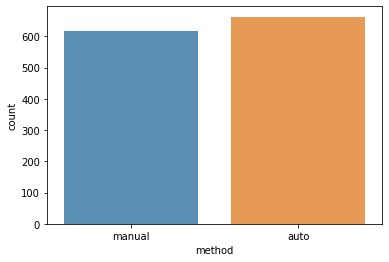

In [22]:
sns.countplot(data=pos, x="method", alpha=.8)

### Распределение по контаминации для всех исследований

<AxesSubplot:xlabel='contamination', ylabel='count'>

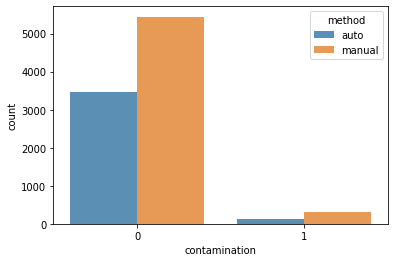

In [23]:
sns.countplot(data=df, x="contamination", hue = 'method', alpha=.8)

## Графики для визуализации связей в данных

### Распределение продолжительности культивирования для положительных результатов в зависимости от группы микроорганизма и метода культивирования

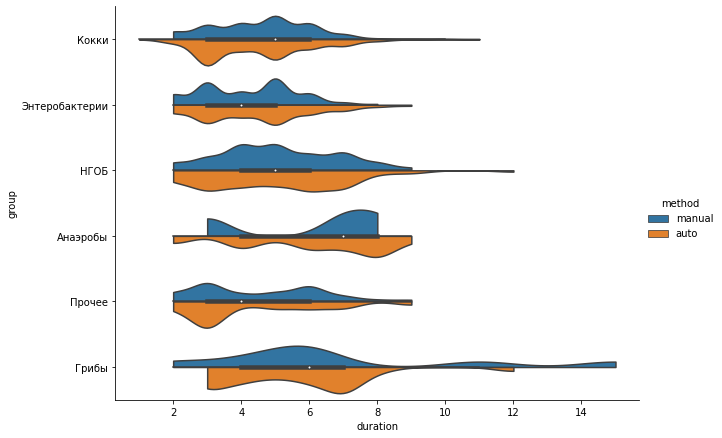

In [24]:

sns.catplot(
    data=pos, x="duration", y="group", hue="method",
    kind="violin", bw=.25, cut=0, split=True, height=6, aspect=1.5
)

### Распределение продолжительности культивирования для положительных результатов в зависимости от отделения и метода культивирования

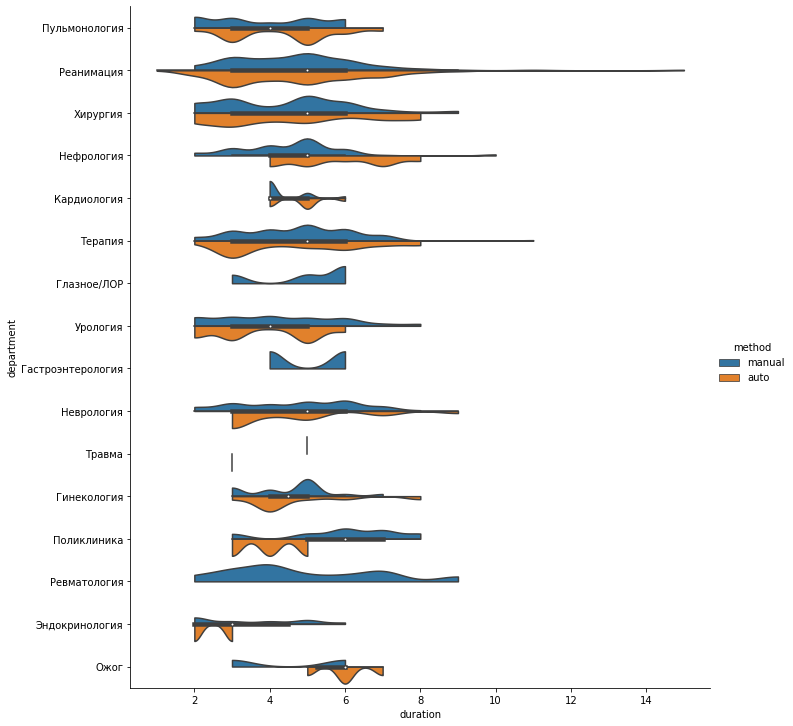

In [25]:
sns.catplot(
    data=pos, x="duration", y="department", hue="method",
    kind="violin", bw=.25, cut=0, split=True, height=10, aspect=1
)

### 20 наиболее частых диагнозов при положительных результатах исследования

<AxesSubplot:xlabel='count', ylabel='diagnosis'>

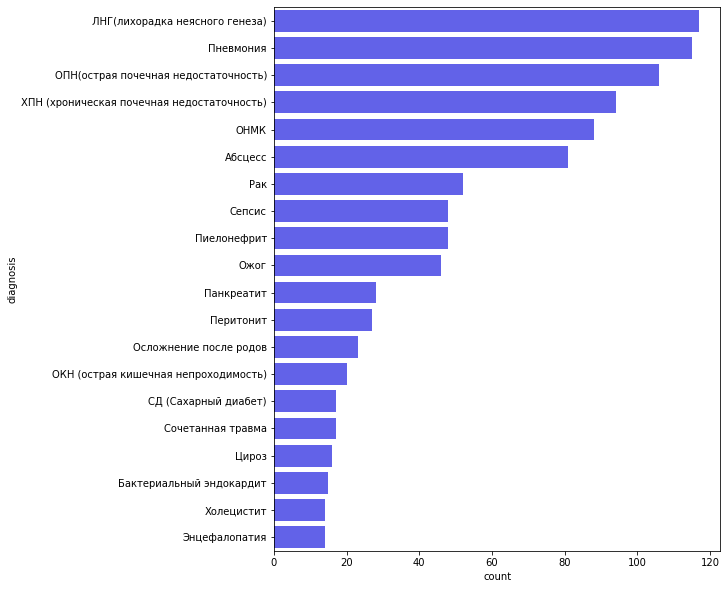

In [26]:
plt.figure(figsize=(8, 10))
desc = pos.groupby('diagnosis').size().nlargest(20).sort_values().index[::-1]
sns.countplot(data=pos, y="diagnosis", alpha=.7, color = 'b', order = desc)

### Связь возбудителей с диагнозами и отделениями

Сводная таблица и тепловая карта по отделениям и количеству выявленных возбудителей из разных групп 

In [28]:
#сводная таблица для отделений и групп возбудителей
pos.pivot_table(
index = 'department',
    values = 'positive',
    columns = 'group',
    aggfunc='count'
)#.sort_values(by = ('sum', 'positive'), ascending = False)

group,Анаэробы,Грибы,Кокки,НГОБ,Прочее,Энтеробактерии
department,,,,,,
Гастроэнтерология,NaN,NaN,2.0,NaN,NaN,NaN
Гинекология,NaN,NaN,18.0,NaN,4.0,4.0
Глазное/ЛОР,NaN,NaN,4.0,NaN,NaN,NaN
Кардиология,NaN,NaN,16.0,6.0,NaN,NaN
Неврология,NaN,5.0,60.0,3.0,5.0,10.0
Нефрология,NaN,NaN,62.0,12.0,5.0,15.0
Ожог,NaN,NaN,2.0,1.0,1.0,2.0
Поликлиника,NaN,NaN,14.0,3.0,NaN,6.0
Пульмонология,2.0,NaN,36.0,5.0,2.0,7.0


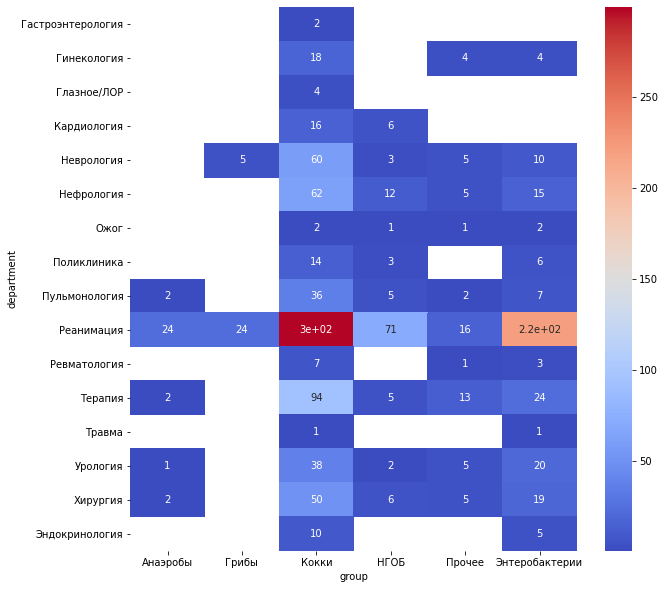

In [29]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(pos.pivot_table(
index = 'department',
    values = 'positive',
    columns = 'group',
    aggfunc='count'
), cmap='coolwarm', annot = True, ax=ax);

Сводная таблица по диагнозам (20 наиболее частых при положительном ответе) и количеству выявленных возбудителей из разных групп

In [30]:
# 20 наиболее частых диагнозов при положительном результате
diag = list(pos.groupby('diagnosis').size().nlargest(20).index)
# выборка с наиболее частыми диагнозами
top20 = pos.query('diagnosis in @diag')

#сводная таблица для 
top20.pivot_table(
index = 'diagnosis',
    values = 'positive',
    columns = 'group',
    aggfunc='count'
)

group,Анаэробы,Грибы,Кокки,НГОБ,Прочее,Энтеробактерии
diagnosis,,,,,,
Абсцесс,1.0,1.0,45.0,15.0,8.0,11.0
Бактериальный эндокардит,NaN,NaN,8.0,4.0,1.0,2.0
ЛНГ(лихорадка неясного генеза),1.0,NaN,71.0,4.0,8.0,33.0
ОКН (острая кишечная непроходимость),NaN,NaN,9.0,1.0,1.0,9.0
ОНМК,2.0,2.0,58.0,6.0,5.0,15.0
ОПН(острая почечная недостаточность),2.0,2.0,50.0,11.0,2.0,39.0
Ожог,NaN,1.0,24.0,6.0,3.0,12.0
Осложнение после родов,NaN,NaN,17.0,NaN,2.0,4.0
Панкреатит,3.0,2.0,11.0,3.0,NaN,9.0


## Обучение модели для предсказания длительности культивирования

### Подготовка признаков для модели и создание выборок

При поступлении в лабораторию известны: отделение, предполагаемый диагноз, задержка с момента забора материала. При исследовании выбирается метод: ручной или автоматический. 
Результат исследования - информация о группе, роде и виде возбудителя - получается через несколько дней и служит для корректировки терапии. Поэтому важно знать, сколько дней потребуется для получения результата при положительном тесте. 

Поэтому по имеющимся данным будем предсказывать время получения результата относительно медианного значения, равного 4 дням. Создадим столбец fast, в котором закодируем целевую переменную, то есть время получения положительного результата: 1 - менее 4 дней, 0 - от 4 дней. Для этого подготовим функцию, которая учитывает информацию о позитивном тесте и о продолжительности культивирования:

In [31]:
def speed(row):
    if row['positive'] == 1:
        if row['duration'] <= 4:
            fast = 1
        else:
            fast = 0
    else:
        fast = 0
    return fast

Применим функцию к датафрейму и создадим новый столбец с целевой переменной:

In [32]:
df['fast'] = df.apply(speed, axis = 1)
print('Доля быстрых положительных результатов:', df.fast.mean())

Доля быстрых положительных результатов: 0.06535947712418301


Выберем столбцы в новый датафрейм:

In [33]:
data = df[['department', 'diagnosis', 'delay', 'method', 'fast']].copy()
data.head()

,department,diagnosis,delay,method,fast
0,Реанимация,ОПН(острая почечная недостаточность),0,auto,0
1,Терапия,ЛНГ(лихорадка неясного генеза),0,manual,0
2,Пульмонология,Бронхиальная астма,0,manual,0
3,Терапия,Цироз,0,manual,0
4,Пульмонология,Пневмония,0,manual,1


Переведем столбцы в категориальные:

In [34]:
categorical = ['department', 'diagnosis', 'method']
for col in categorical:
    data[col] = data[col].astype('category')

Разделим на обучающую и тестовую выборки:

In [35]:
# создаем таблицы с признаками и с целевым признаком:
features = data.drop(['fast'], axis=1)
target = data['fast']


# выделяем из данных обучающую выборку с 80% данных
X_train, X_test, y_train, y_test = (train_test_split(features, target, train_size=0.8,
                                                     random_state=38))

len(y_train)

7466

Подготовим гиперпараметры и модель LGBMClassifier для обучения с кросс-валидацией, метрика для оценки - F1:

In [36]:
# создадим список гиперпараметров
lgbm_parameters = {
    'num_leaves': [9, 30],
    'n_estimators': [95, 100],
    'learning_rate': [0.1, 1],
    'max_depth': [7, 9]
}

# создадим модель LGBMClassifier и передадим ее с параметрами для GridSearchCV
lgbm = LGBMClassifier(random_state=38, class_weight = 'balanced')
lgbm = GridSearchCV(lgbm,
                    param_grid=lgbm_parameters,
                    scoring='f1',
                    cv=5)

Выполним обучение:

In [37]:
%%time
# выполним обучение модели
lgbm.fit(X_train, y_train)

CPU times: total: 48.3 s
Wall time: 16.1 s


GridSearchCV(cv=5,
             estimator=LGBMClassifier(class_weight='balanced', random_state=38),
             param_grid={'learning_rate': [0.1, 1], 'max_depth': [7, 9],
                         'n_estimators': [95, 100], 'num_leaves': [9, 30]},
             scoring='f1')

Выведем наилучшие подобранные гиперпараметры, значение метрики, сохраним модель с наилучшими гиперпараметрами:

In [38]:
print("Подобранные значения гиперпараметров для LGBM Classifier :", lgbm.best_params_)
print("Значение F1 для подобранных гиперпараметров LGBM Classifier:",lgbm.best_score_)

# сохраним модель LGBMClassifier
lgbm_clf = lgbm.best_estimator_

Подобранные значения гиперпараметров для LGBM Classifier : {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 100, 'num_leaves': 30}
Значение F1 для подобранных гиперпараметров LGBM Classifier: 0.17496913677925852


Вычислим значение f1 и ROC AUC для тестовой выборки:

In [39]:
#проверяем на тестовой выборке 
predictions = lgbm_clf.predict(X_test)
f1_lgbm = f1_score(y_test, predictions)
print("F1 для тестовой выборки:", f1_lgbm)

F1 для тестовой выборки: 0.19220779220779224


In [40]:
#вычислим вероятности положительного класса для тестовой выборки
lgbm_probs = lgbm_clf.predict_proba(X_test)[:,1]
#рассчитаем значение ROC AUC
lgbm_auc = roc_auc_score(y_test, lgbm_probs)
print('Значение ROC AUC = %.3f' % (lgbm_auc))

Значение ROC AUC = 0.677


Значение f1 очень низкое, но ROC AUC выше 0.5. Визуализируем кривую AUC ROC:

In [41]:
#вычислим значения FPR и TPR на основе определенных ранее вероятностей положительного результата на тестовой выборке
fpr_lgbm, tpr_lgbm, treshold_lgbm = roc_curve(y_test, lgbm_probs)

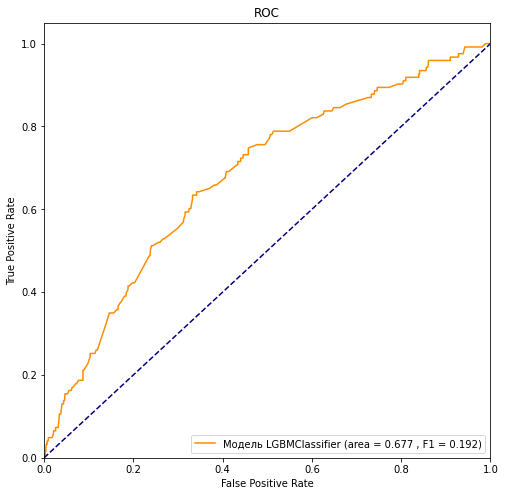

In [42]:
plt.figure(figsize=(8,8))

# график для модели LGBMClassifier
plt.plot(fpr_lgbm, tpr_lgbm, color='darkorange',
         label='Модель LGBMClassifier (area = %0.3f , F1 = %0.3f)' % (lgbm_auc, f1_lgbm))

#диагональ
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

**Вывод** 
Подготовленная модель выполняет предсказания, будет ли быстро получен положительный результат, с немного большей вероятностью, чем случайный выбор.